### Match Annotations

In [5]:
### Imports
# Standard library imports
import json
import os
import shutil
import logging
import sys

# Third-party imports
# Data handling
import numpy as np
import pandas as pd

# Image I/O and processing
import tifffile as tiff
from nd2reader import ND2Reader
from skimage.morphology import remove_small_objects

# Deep learning and segmentation
from csbdeep.utils import Path, normalize
from stardist import (
    fill_label_holes,
    random_label_cmap,
    calculate_extents,
    gputools_available,
)
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from tensorflow.keras.utils import Sequence

# Tracking
import btrack
from btrack.constants import BayesianUpdates

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Utilities
from tqdm import tqdm

from datetime import datetime

import pickle

In [6]:
## Variables
## Directory Paths
# Input
IMG_DIR = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs'
APO_DIR = '/mnt/imaging.data/PertzLab/apoDetection/ApoptosisAnnotation'
EXPERIMENT_INFO = '/mnt/imaging.data/PertzLab/apoDetection/List of the experiments.csv'
DETAILS_DIR = '../data/details_test'
TRACKED_MASK_DIR = '../data/tracked_masks'

# Output
MASK_DIR = '../data/apo_masks'    # Stardist label predictions
CSV_DIR = '../data/apo_match_csv_test'    # File with manual and stardist centroids
DF_DIR = '../data/summary_dfs'
CROPS_DIR = '../data/apo_crops_test'    # Directory with .tif files for QC
WINDOWS_DIR = '/home/nbahou/myimaging/apoDet/data/windows_test'    # Directory with crops for scDINO
RANDOM_DIR = os.path.join(WINDOWS_DIR, 'random')
CLASS_DCT_PATH = './extras/class_dicts'


## Processing Configuration
COMPARE_2D_VERS = True
SAVE_MASKS = True
LOAD_MASKS = True
USE_GPU = True
MIN_NUC_SIZE = 200

## Tracking Parameters
BT_CONFIG_FILE = "extras/cell_config.json"  # Path to btrack config file
EPS_TRACK = 70         # Tracking radius [px]
TRK_MIN_LEN = 25       # Minimum track length [frames]

#
MAX_TRACKING_DURATION = 20    # In minutes
FRAME_INTERVAL = 5    # minutes between images we want

WINDOW_SIZE = 61


## Logger Set Up
#logging.shutdown()    # For jupyter notebooks
logger = logging.getLogger(__name__)
#if logger.hasHandlers():
#    logger.handlers.clear()
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define log directory and ensure it exists
log_dir = "./logs"  # Folder for logs
os.makedirs(log_dir, exist_ok=True)  # Create directory if it doesn't exist

log_filename = f"match_annos_{timestamp}.log"
log_path = os.path.join(log_dir, log_filename)

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_path),
        logging.StreamHandler(sys.stdout)  # Outputs to console too
    ],
    force = True
)

# Create a logger instance
logger = logging.getLogger(__name__)

# Only forward Warnings/Errors/Critical from btrack
logging.getLogger('btrack').setLevel(logging.WARNING)


In [7]:
def load_image_stack(path):
    """
    Load an image stack from a file based on its extension.
    
    Uses tifffile for TIFF files and ND2Reader for ND2 files.
    """
    if path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        return tiff.imread(path)
    elif path.endswith('.nd2'):
        # Load ND2 file using ND2Reader and convert it to a numpy array
        with ND2Reader(path) as nd2:
            return np.array(nd2)
    else:
        raise ValueError(f"Unsupported file format for file: {path}")

def get_image_paths(directory):
    """
    Returns a list of absolute paths of all TIFF and ND2 files in a directory.
    """
    valid_extensions = ('.tif', '.tiff', '.nd2')
    paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(valid_extensions)
    ]
    return sorted(paths)



def match_annotations(apo_annotations, details, tracked_masks, gt_filtered):
    """
    Match manual annotations with stardist detections.
    
    Parameters:
        apo_annotations (DataFrame): DataFrame containing manual annotations.
        details (dict or list): Details loaded from the stardist output, e.g., centroids.
        tracked_masks (ndarray): The mask array with btrack track IDs.
        gt_filtered (ndarray): The filtered segmentation array.
        
    Returns:
        DataFrame: The apo_annotations DataFrame updated with matching information.
        dict: A dictionary containing evaluation metrics (e.g. num_matches, num_mismatches,
              distances for alternative matching, etc.)
    """
    delta_ts = []
    corresponding_objs = []
    corresponding_tracks = []
    strdst_x = []
    strdst_y = []
    dist_paolo_stardist = []
    dist_alt_matching = []
    num_matches = 0
    num_mismatches = 0

    # Loop over each annotation
    for _, row in tqdm(apo_annotations.iterrows(), total=len(apo_annotations), desc="Processing Annotations"):
        t, x, y = int(row['t']), int(row['x']), int(row['y'])
        centroids = np.array(details[t]['points'])  # Convert list to NumPy array
        
        # Compute Euclidean distances
        distances = np.linalg.norm(centroids - np.array([x, y]), axis=1)
        match_index = np.argmin(distances)
        alt_distance_to_paolo = distances[match_index]
        dist_alt_matching.append(alt_distance_to_paolo)

        # Check for a perfect match using the mask values
        if tracked_masks[t, y, x] != 0:
            corresponding_tracks.append(tracked_masks[t, y, x])
            corresponding_objs.append(gt_filtered[t, y, x])
            delta_ts.append(0)
            num_matches += 1
        else:
            t_start = max(0, t - 3)
            t_end = min(t + 3 + 1, tracked_masks.shape[0])
            previous_frames = tracked_masks[t_start:t_end, y, x]
            if previous_frames.size > 0:
                counts = np.bincount(previous_frames)
                match_id = np.argmax(counts)
            else:
                match_id = 0

            if match_id == 0:
                num_mismatches += 1
            else:
                num_matches += 1

            # Search adjacent frames for a matching track
            for delta in [0, 1, -1, 2, -2, 3, -3]:
                if (t + delta) in range(t_start, t_end):
                    if tracked_masks[t + delta, y, x] == match_id:
                        corresponding_tracks.append(match_id)
                        corresponding_objs.append(gt_filtered[t + delta, y, x])
                        delta_ts.append(delta)
                        break

        # Extract centroid of the best matching object
        centroids = np.array(details[t + delta_ts[-1]]['points'])
        match_centroid = centroids[corresponding_objs[-1] - 1] if corresponding_objs[-1] > 0 else (9999, 9999)
        strdst_x.append(match_centroid[1])
        strdst_y.append(match_centroid[0])
        # Compute distance for validation or plotting
        distance_to_paolo = np.sqrt(((match_centroid[1] - row['x']) ** 2 + (match_centroid[0] - row['y']) ** 2))
        dist_paolo_stardist.append(distance_to_paolo)

    # Update the apo_annotations DataFrame
    apo_annotations['matching_object'] = corresponding_objs
    apo_annotations['matching_track'] = corresponding_tracks
    apo_annotations['strdst_x'] = strdst_x
    apo_annotations['strdst_y'] = strdst_y
    apo_annotations['delta_ts'] = delta_ts

    metrics = {
        'num_matches': num_matches,
        'num_mismatches': num_mismatches,
        'dist_paolo_stardist': dist_paolo_stardist,
        'dist_alt_matching': dist_alt_matching
    }

    return apo_annotations, metrics


In [8]:
# Load image paths in specified directory
logger.info("Starting Image Processing")
image_paths = get_image_paths(os.path.join(IMG_DIR))
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths[:2]]    ### TODO remove :2 here, was only for testing
logger.info(f"Detected {len(filenames)} files in specified directories.")
#print(filenames)

# TODO Create directories for saving if they do not exist
output_dirs = [CSV_DIR, MASK_DIR, DF_DIR, CROPS_DIR, CLASS_DCT_PATH, WINDOWS_DIR]
for path in output_dirs:
    os.makedirs(path, exist_ok=True)


## Lists and counters for evaluation of the matching and cropping process
# Initialize list to collect distances between stardist and manual annotations for evaluation
dist_paolo_stardist = []
dist_alt_matching = []
# Initialize counter for evaluation of num matches/mismatches
num_matches = 0
num_mismatches = 0
# initalize a list to investigate track lengths after apoptosis
survival_times = []


# Loop over all files in target directory (predict labels, track and crop windows for each)
logger.info("Starting to process files.")
for path, filename in zip(image_paths, filenames):
    logger.info(f"Processing {filename}")



    ### Match manual and stardist annotations
    logger.info("\tMatching manual and stardist annotations")
    # Read CSV with manual apoptosis annotations 
    apo_file = os.path.join(APO_DIR, f'{filename}.csv')
    apo_annotations = pd.read_csv(apo_file, header=None, names=['filename', 'x', 'y', 't'])

    # Read details file from stardist (with centroids, etc.)
    details_path = os.path.join(DETAILS_DIR, f'{filename}.pkl')
    with open(details_path, 'rb') as f:
        details = pickle.load(f)

    # Load mask file with track_ids
    mask_path = os.path.join(TRACKED_MASK_DIR, f'{filename}.npz')
    loaded_data = np.load(mask_path)  # Load the .npz file
    tracked_masks = loaded_data['gt']

    # Load stardist segmentation masks
    mask_path = os.path.join(MASK_DIR, f'{filename}.npz')
    loaded_data = np.load(mask_path)  # Load the .npz file
    gt_filtered = loaded_data['gt']      

    apo_annotations, metrics = match_annotations(apo_annotations, details, tracked_masks, gt_filtered)

    num_matches += metrics['num_matches']
    num_mismatches += metrics['num_mismatches']
    dist_paolo_stardist.append(metrics['dist_paolo_stardist'])
    dist_alt_matching.append(metrics['dist_alt_matching'])
    

    # Save again as CSV with added stardist centroids      
    apo_annotations.to_csv(os.path.join(CSV_DIR, f'{filename}.csv'), index=False)
    logger.info(f"\t\tApo-Annotations with stardist centroids saved at: {os.path.join(CSV_DIR, f'{filename}.csv')}")




2025-03-19 17:54:24,904 - __main__ - INFO - Starting Image Processing
2025-03-19 17:54:24,908 - __main__ - INFO - Detected 2 files in specified directories.
2025-03-19 17:54:24,917 - __main__ - INFO - Starting to process files.
2025-03-19 17:54:24,918 - __main__ - INFO - Processing Exp01_Site01
2025-03-19 17:54:24,919 - __main__ - INFO - 	Matching manual and stardist annotations


Processing Annotations: 100%|█████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 8085.18it/s]

2025-03-19 17:54:32,275 - __main__ - INFO - 		Apo-Annotations with stardist centroids saved at: ../data/apo_match_csv_test/Exp01_Site01.csv
2025-03-19 17:54:32,276 - __main__ - INFO - Processing Exp01_Site02
2025-03-19 17:54:32,276 - __main__ - INFO - 	Matching manual and stardist annotations



Processing Annotations: 100%|█████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 7141.16it/s]

2025-03-19 17:54:39,670 - __main__ - INFO - 		Apo-Annotations with stardist centroids saved at: ../data/apo_match_csv_test/Exp01_Site02.csv


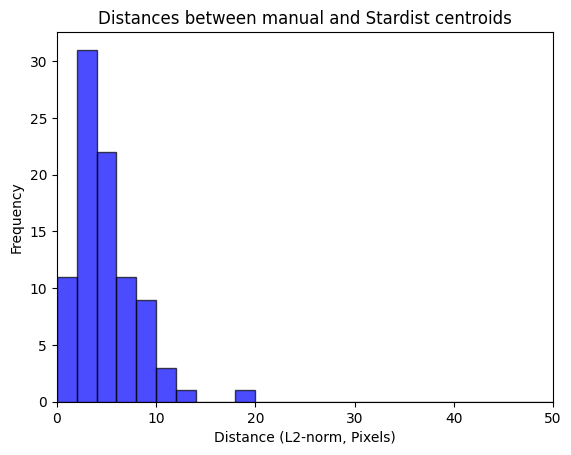

In [9]:
# Create histogram
dist_paolo_stardist_flat = np.concatenate(dist_paolo_stardist).tolist()
dist_alt_matching_flat = np.concatenate(dist_alt_matching).tolist()

plt.hist(dist_paolo_stardist_flat, bins=25, range=(0, 50), color='blue', edgecolor='black', alpha=0.7)
plt.xlim(0, 50)


# Labels and title
plt.xlabel('Distance (L2-norm, Pixels)')
plt.ylabel('Frequency')
plt.title('Distances between manual and Stardist centroids')

# Show plot
plt.show()

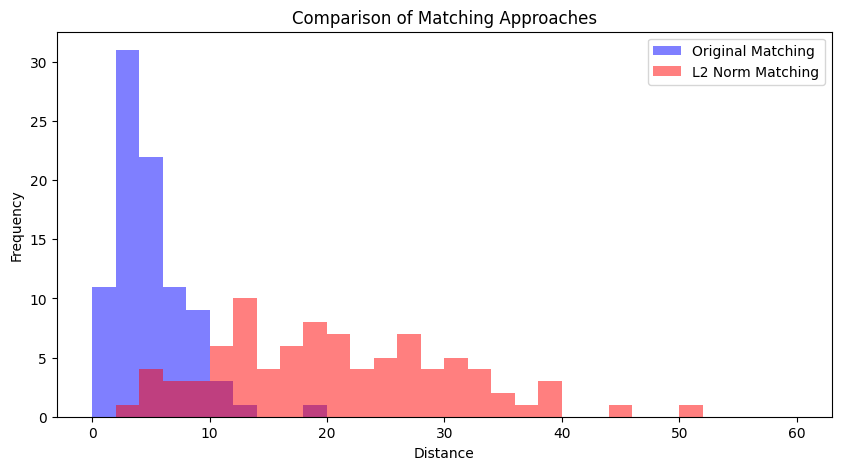

Original Matching - Mean Distance: 4.654222065130671
L2 Norm Matching - Mean Distance: 20.8033545248053
Original Matching - Median Distance: 4.123105625617661
L2 Norm Matching - Median Distance: 19.849433241279208
Original Matching - Min/Max: 1.0 / 19.4164878389476
L2 Norm Matching - Min/Max: 3.605551275463989 / 50.24937810560445


In [10]:
# Ensure lists are NumPy arrays for efficient calculations
dist_paolo_stardist = np.array(dist_paolo_stardist_flat)
dist_alt_matching = np.array(dist_alt_matching_flat)


# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(dist_paolo_stardist_flat, bins=30, alpha=0.5, label="Original Matching", color='blue', range = (0, 60))
plt.hist(dist_alt_matching_flat, bins=30, alpha=0.5, label="L2 Norm Matching", color='red', range = (0, 60))
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Comparison of Matching Approaches")
plt.legend()
plt.show()

# Print summary statistics
print("Original Matching - Mean Distance:", np.mean(dist_paolo_stardist))
print("L2 Norm Matching - Mean Distance:", np.mean(dist_alt_matching))
print("Original Matching - Median Distance:", np.median(dist_paolo_stardist))
print("L2 Norm Matching - Median Distance:", np.median(dist_alt_matching))
print("Original Matching - Min/Max:", np.min(dist_paolo_stardist), "/", np.max(dist_paolo_stardist))
print("L2 Norm Matching - Min/Max:", np.min(dist_alt_matching), "/", np.max(dist_alt_matching))


In [24]:
np.mean(metrics['dist_alt_matching'])

20.08423130913089